#### iLQR for point mass example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from ocp import *
from costs import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Create point mass system with dimension 2 (double integrator)

In [27]:
dt = 0.05
T = 100
Dx, Du = 4, 2
A = np.eye(Dx)
A[:2,2:] = np.eye(2)*dt
B = np.zeros((Dx, Du))
B[2:, :] = np.eye(Du)

sys = LinearSystem(A, B)

#### Set initial state and control trajectory

In [39]:
x0 = np.zeros(Dx)
x0[3] = 10
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [40]:
Q = np.eye(sys.Dx)*.1
#Q[0:2,0:2] *= 0.0
Qf = np.eye(sys.Dx)*1
#Qf[0:2,0:2] *= 0.0
R = np.eye(sys.Du)*.1
mu = 1e-6

#### Set reference target

In [41]:
x_ref = np.array([2, 2, 0,0])

### iLQR using cost model

#### Define the cost

In [42]:
#The costs consist of: a) state tracking (Q), b) control regularization (R)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T

runningStateCost = CostModelQuadratic(sys, Q, x_ref = x_ref)
runningControlCost = CostModelQuadratic(sys, None, R)
runningCost = CostModelSum(sys, [runningStateCost, runningControlCost])

terminalStateCost = CostModelQuadratic(sys,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost])

costs = [runningCost]*T + [terminalCost]

#### Construct ILQR

In [43]:
ilqr_cost = ILQR(sys)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)

#### Solve and Plot

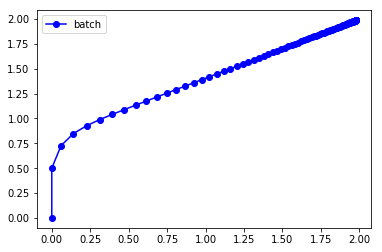

In [46]:
n_iter = 10
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

clear_output()
plt.plot(xs_batch[:,0], xs_batch[:,1], 'b-o', label='batch')
plt.legend()
plt.show()